In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dmyplant2
dmyplant2.cred()
mp = dmyplant2.MyPlant(3600)

In [43]:
dval = dmyplant2.Validation.load_def_csv("input2.csv")
dval;

In [44]:
i = 5
vale = dval.iloc[i][['serialNumber','Validation Engine','val start']]

In [45]:
e=dmyplant2.Engine.from_sn(mp,vale['serialNumber'], valstart=vale['val start'])
pd.DataFrame.from_dict(e.dash, orient='index').T

,Name,Engine ID,Design Number,Engine Type,Engine Version,P,P_nom,BMEP,serialNumber,id,Count_OpHour,val start,oph@start,oph parts,LOC
0,BMW Regensburg,M2,I448,616,J01,16,2744.9,22.0,1243362,157701,71738.0,2020-09-07,0,71738,None


In [47]:
#e.get_messages()

In [48]:
%reload_ext autoreload
%autoreload 2
from dfsm import msgFSM
fsm = msgFSM(e)
fsm.run() # run the Finite State Machine
fsm.store()

Scan Messages: 100%|████████████████████████████████████████████████████| 31796/31796 [00:02<00:00, 12631.11 messages/s]


In [49]:
%reload_ext autoreload
%autoreload 2
from dfsm import FSM
FSM.dot('FSM.dot')

In [50]:
fsm._runlog;

In [51]:
rdf = pd.DataFrame(fsm._starts)
rda = rdf[['success','mode','cumtime','start-preparation','starter','hochlauf','idle','synchronize','load-ramp']]
#rda = rdf[((rdf['mode'] == 'AUTO') & (rdf['success'] == True))]
#rda = rdf[((rdf['mode'] == 'AUTO') & (rdf['success'] == True) & (rdf['synchronize'] < 300.0) & (rdf['start-preparation'] < 300.0))]
#rda = rdf[((rdf['success'] == True) & (rdf['start-preparation'] < 1000.0))]
#rda = rdf[((rdf['success'] == True))]
rda.round(2)

,success,mode,cumtime,start-preparation,starter,hochlauf,idle,synchronize,load-ramp
0,False,MANUAL,436.57,356.55,4.75,40.94,34.33,NaN,NaN
1,False,MANUAL,405.37,375.22,4.43,25.72,NaN,NaN,NaN
2,False,MANUAL,1090.13,1090.13,NaN,NaN,NaN,NaN,NaN
3,True,MANUAL,966.02,197.15,4.74,22.43,640.54,101.15,8196.20
4,True,MANUAL,259.17,186.92,4.64,25.01,26.95,15.64,281.99
...,...,...,...,...,...,...,...,...,...
348,True,AUTO,378.21,96.24,4.24,26.66,227.88,23.20,30363.70
349,False,MANUAL,70.85,70.85,NaN,NaN,NaN,NaN,NaN
350,False,MANUAL,77.27,77.27,NaN,NaN,NaN,NaN,NaN
351,True,AUTO,151.54,64.96,5.16,20.30,4.14,56.98,54442.82


In [52]:
rda.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
cumtime,353.0,157.59,125.70,0.10,113.27,142.94,175.33,1162.64
start-preparation,353.0,80.63,68.17,0.10,60.63,81.53,83.65,1090.13
starter,281.0,4.80,0.53,1.62,4.44,4.74,5.04,7.77
hochlauf,280.0,22.04,4.90,6.66,19.06,21.89,24.31,72.71
idle,269.0,43.75,105.77,3.43,3.93,4.24,4.64,1078.33
synchronize,252.0,31.26,21.04,1.71,18.60,25.58,40.38,189.65
load-ramp,246.0,34557.30,28201.33,71.72,7187.47,31360.14,62350.00,86076.62


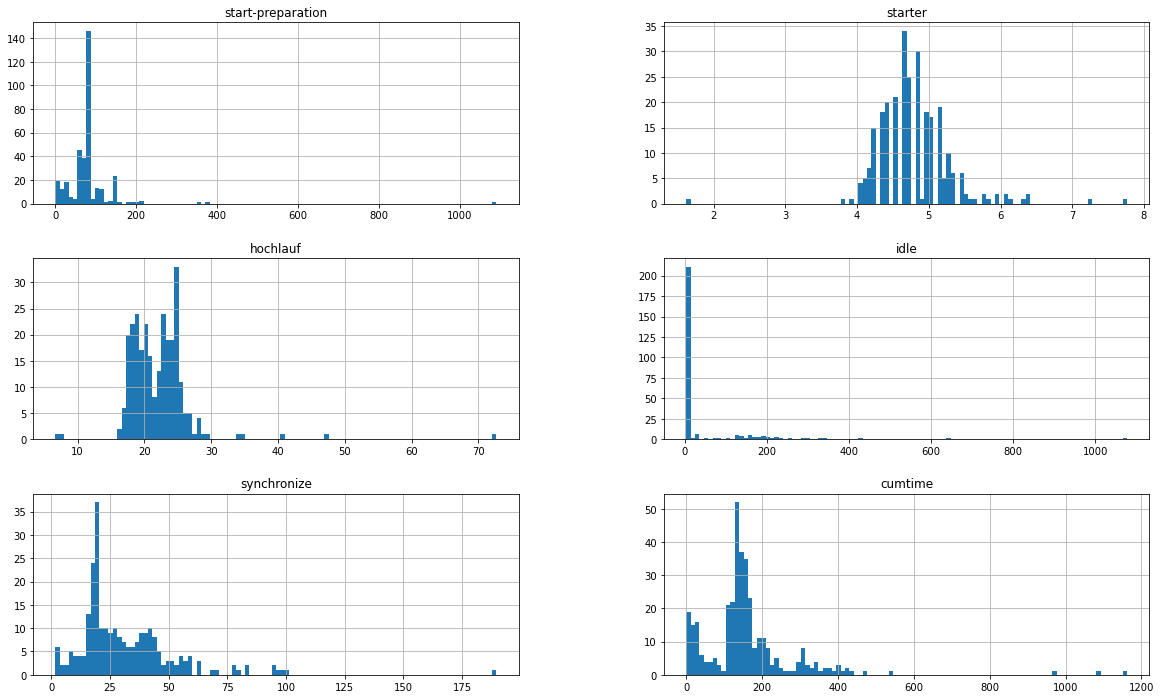

In [54]:
rda[['start-preparation','starter','hochlauf','idle','synchronize','cumtime']].hist(figsize = (20,12), bins=100);
#rda.hist(figsize = (20,12), bins=100);

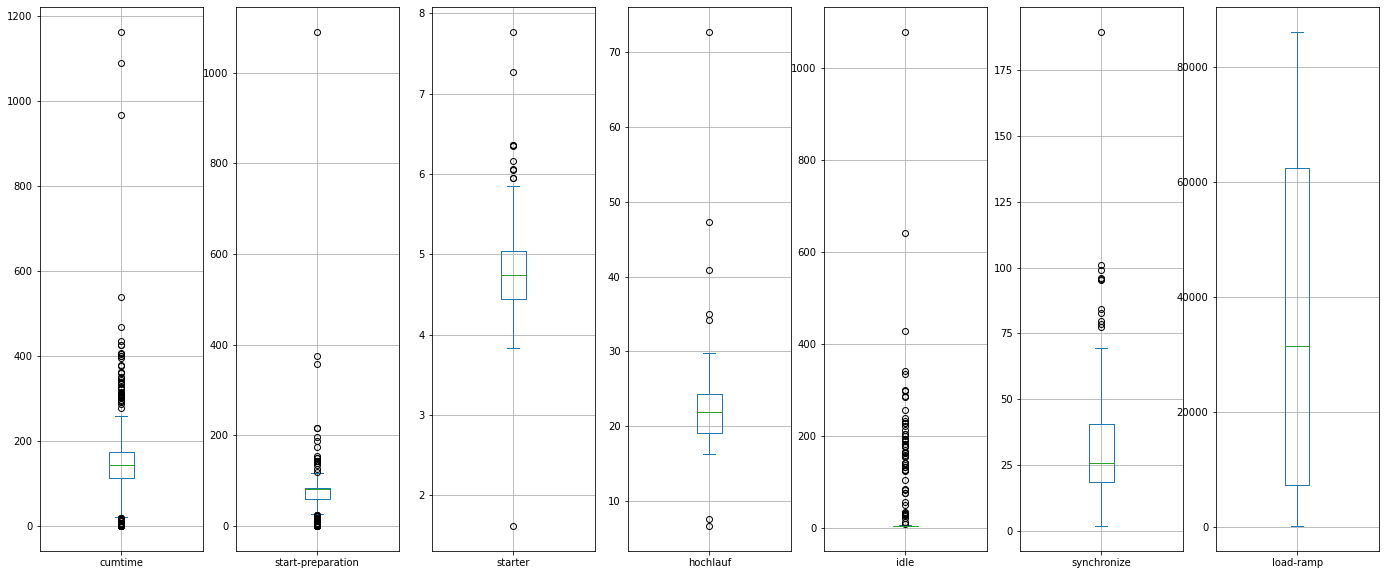

In [55]:
rda.plot.box(subplots=True, grid = True, figsize=(24,10), layout=(1,7));

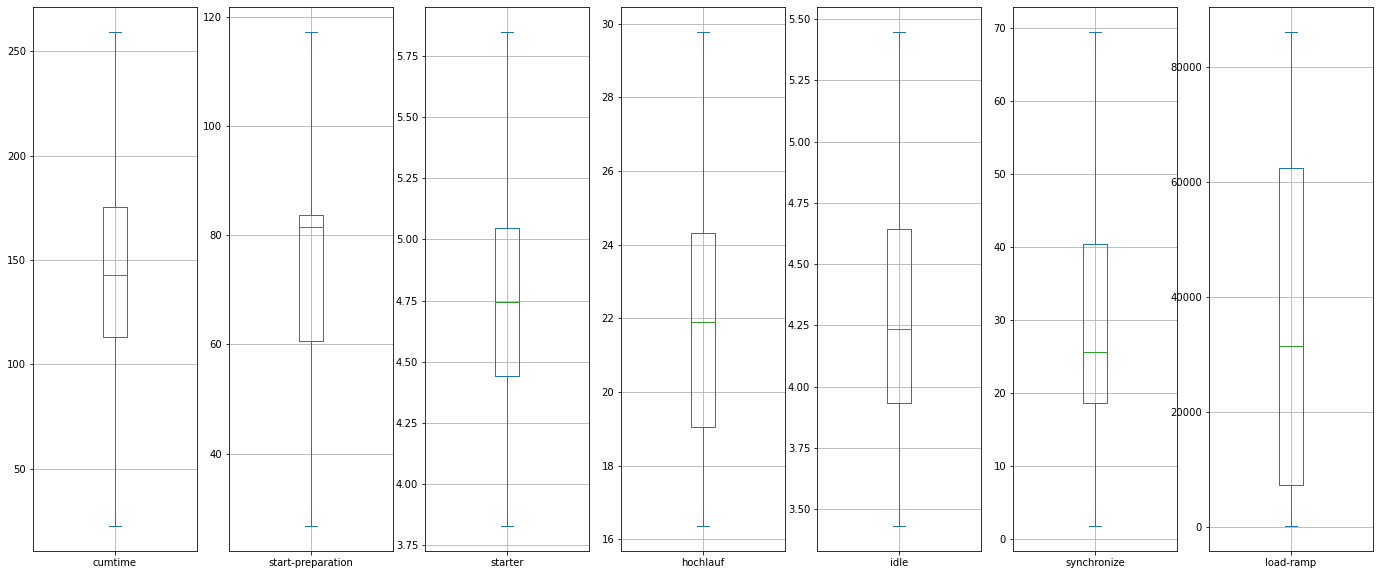

In [56]:
rda.plot.box(subplots=True, grid = True, figsize=(24,10), layout=(1,7), sym='');

In [57]:
round((rdf[rdf.success].shape[0] / rdf.shape[0]) * 100,1)

70.0

In [59]:
for i,c in rdf.iterrows():
    if len(c['alarms']) > 0:
        print(f"\nStartversuch: {i}, Success: {c['success']}")
        for a in c['alarms']:
            print(f"{c['mode']:15} {a['state']:20} {pd.to_datetime(int(a['msg']['timestamp'])*1e6).strftime('%d.%m.%Y %H:%M:%S')} {a['msg']['name']} {a['msg']['message']}")



KeyError: 'alarms'

<Figure size 432x288 with 0 Axes>

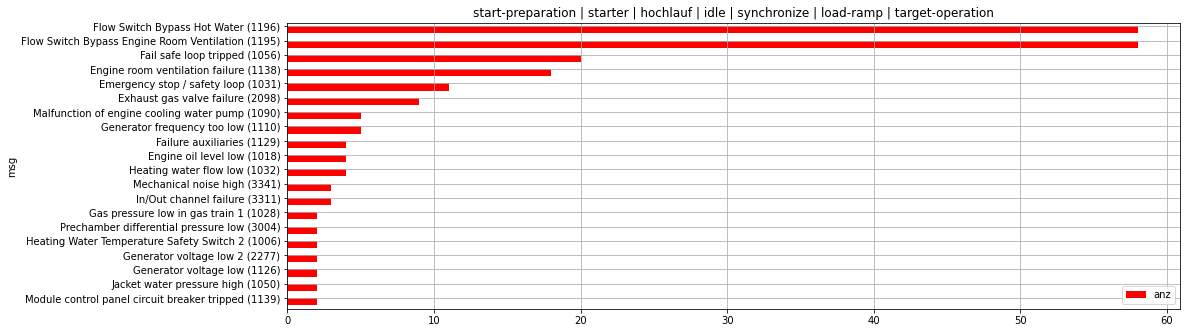

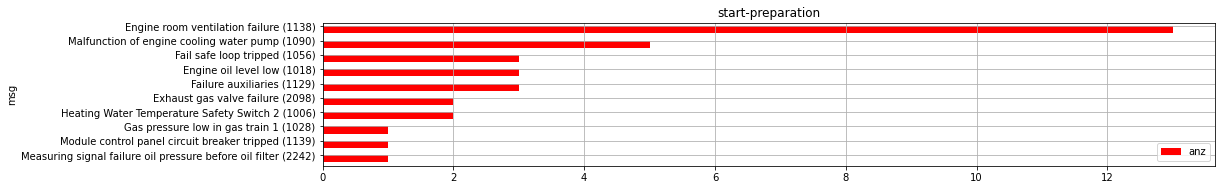

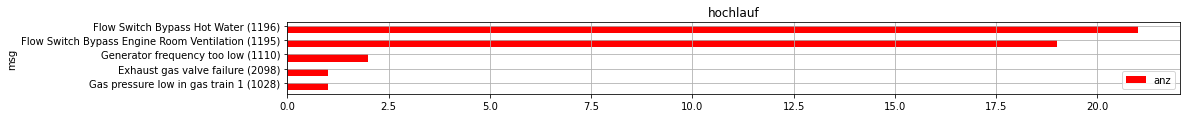

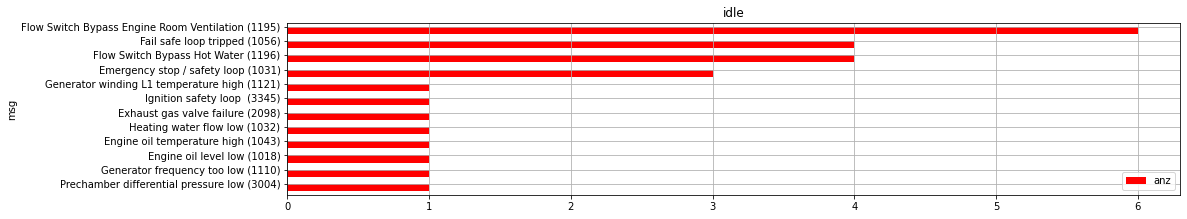

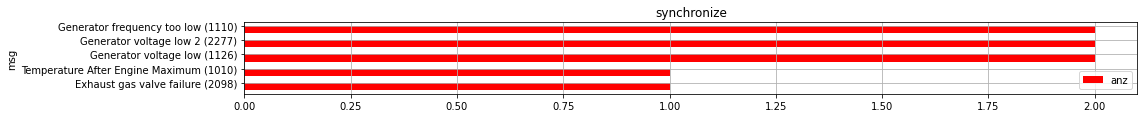

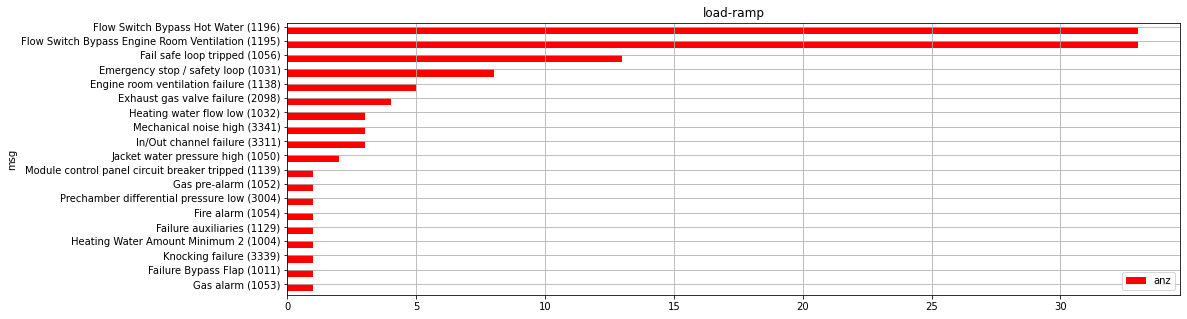

In [15]:
phases = [['start-preparation','starter','hochlauf','idle','synchronize','load-ramp','target-operation'],'start-preparation','starter','hochlauf','idle','synchronize','load-ramp','target-operation']
fig = plt.figure();
color = 'red'

for phase in phases:
    al = fsm.alarms_pareto(phase)[:20]
    if not al.empty:
        al['msg'] = al['msg'] + ' (' + al['name'] + ')'
        al.set_index('msg').sort_values(by = "anz",ascending=True).plot.barh(y=['anz'],figsize=(16,len(al) / 3.8), color=[color], position = 1.0, grid=True, title=' | '.join(phase) if type(phase) == list else phase);
        plt.plot();


<Figure size 432x288 with 0 Axes>

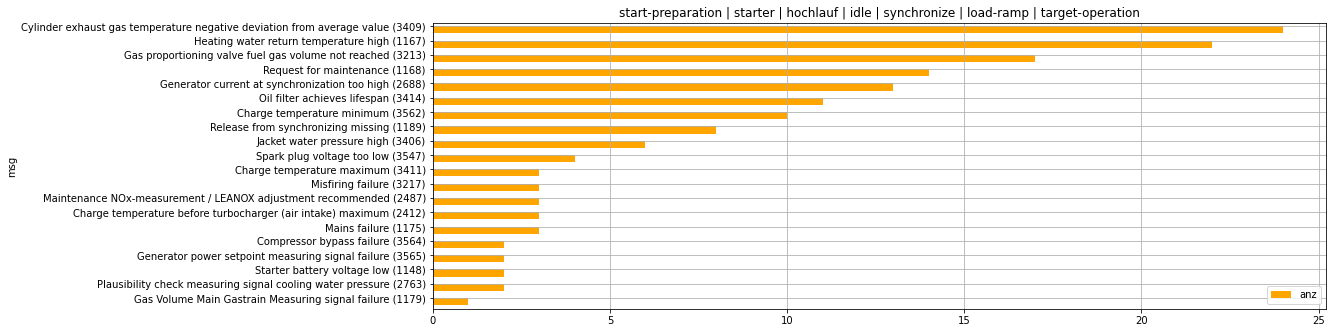

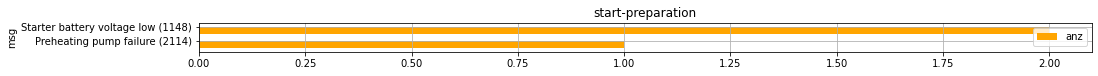

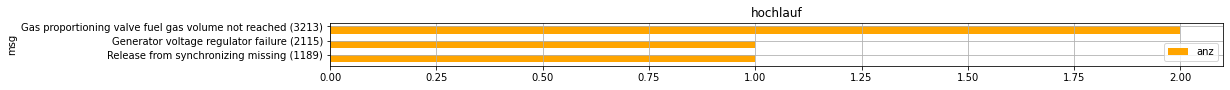

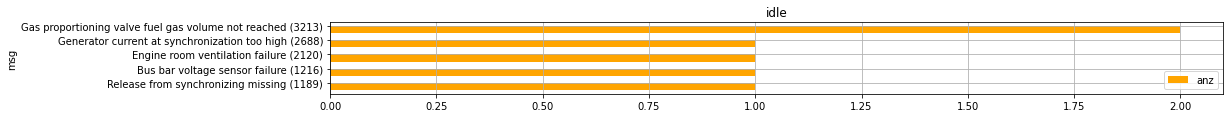

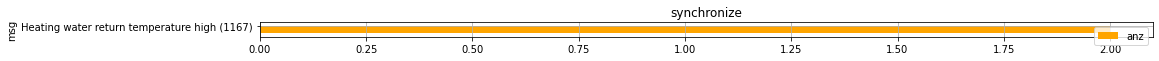

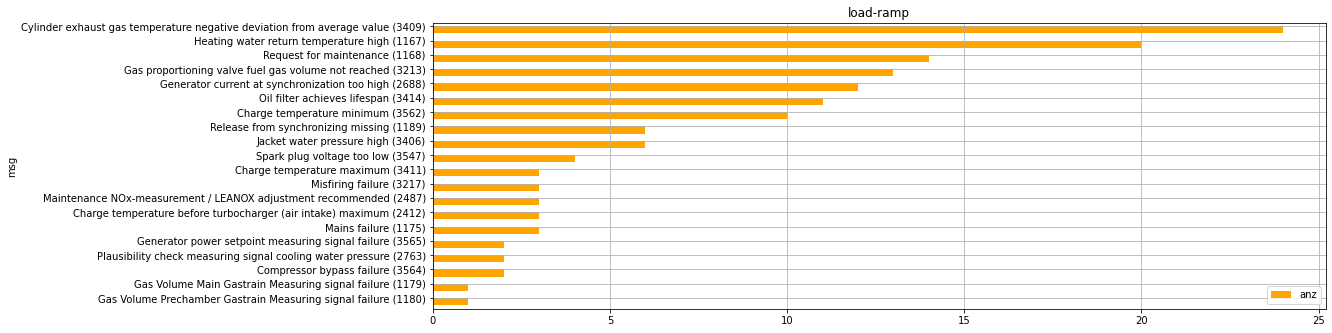

In [16]:
phases = [['start-preparation','starter','hochlauf','idle','synchronize','load-ramp','target-operation'],'start-preparation','starter','hochlauf','idle','synchronize','load-ramp','target-operation']
fig = plt.figure();
color = 'orange'

for phase in phases:
    al = fsm.warnings_pareto(phase)[:20]
    if not al.empty:
        al['msg'] = al['msg'] + ' (' + al['name'] + ')'
        al.set_index('msg').sort_values(by = "anz",ascending=True).plot.barh(y=['anz'],figsize=(16,len(al) / 3.8), color=[color], position = 1.0, grid=True, title=' | '.join(phase) if type(phase) == list else phase);
        plt.plot();


In [17]:
#fsm.save_messages('msg4.txt')

In [ ]:
#fsm.store()